# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is that probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# 0.75 has a 75% probability to be larger than a number randonmly drawn from the interval (0,1)
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network. His blog post offers a very clear explanation to the skip-gram model and is extremely helpful in understanding the concept.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [10]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [14]:
epochs = 20
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/50 Iteration: 100 Avg. Training loss: 5.6400 0.0198 sec/batch
Epoch 1/50 Iteration: 200 Avg. Training loss: 5.6231 0.0169 sec/batch
Epoch 1/50 Iteration: 300 Avg. Training loss: 5.5105 0.0168 sec/batch
Epoch 1/50 Iteration: 400 Avg. Training loss: 5.5982 0.0166 sec/batch
Epoch 1/50 Iteration: 500 Avg. Training loss: 5.5055 0.0161 sec/batch
Epoch 1/50 Iteration: 600 Avg. Training loss: 5.5621 0.0169 sec/batch
Epoch 1/50 Iteration: 700 Avg. Training loss: 5.5449 0.0167 sec/batch
Epoch 1/50 Iteration: 800 Avg. Training loss: 5.5397 0.0161 sec/batch
Epoch 1/50 Iteration: 900 Avg. Training loss: 5.4913 0.0172 sec/batch
Epoch 1/50 Iteration: 1000 Avg. Training loss: 5.4065 0.0164 sec/batch
Nearest to nine: reductio, nationalized, release, electorally, oni, missionary, wagoner, gagnon,
Nearest to three: demyelination, poets, deeds, roberto, turquoise, then, handicraft, qualify,
Nearest to from: wehrmacht, cryptologia, leonhart, theseus, migrants, acyclic, bcc, preconceptions,
Nearest 

Epoch 1/50 Iteration: 4100 Avg. Training loss: 4.6864 0.0172 sec/batch
Epoch 1/50 Iteration: 4200 Avg. Training loss: 4.6582 0.0167 sec/batch
Epoch 1/50 Iteration: 4300 Avg. Training loss: 4.6303 0.0172 sec/batch
Epoch 1/50 Iteration: 4400 Avg. Training loss: 4.6239 0.0165 sec/batch
Epoch 1/50 Iteration: 4500 Avg. Training loss: 4.6040 0.0162 sec/batch
Epoch 1/50 Iteration: 4600 Avg. Training loss: 4.6266 0.0164 sec/batch
Epoch 2/50 Iteration: 4700 Avg. Training loss: 4.5883 0.0125 sec/batch
Epoch 2/50 Iteration: 4800 Avg. Training loss: 4.5287 0.0161 sec/batch
Epoch 2/50 Iteration: 4900 Avg. Training loss: 4.4991 0.0166 sec/batch
Epoch 2/50 Iteration: 5000 Avg. Training loss: 4.5283 0.0167 sec/batch
Nearest to nine: actress, d, eight, broadcaster, one, missionary, four, kermit,
Nearest to three: recipient, roberto, american, guitarist, zero, james, bordered, isbn,
Nearest to from: cryptologia, wehrmacht, migrants, cultured, estimated, palermo, theseus, showcases,
Nearest to if: scalar

Epoch 2/50 Iteration: 8100 Avg. Training loss: 4.3177 0.0183 sec/batch
Epoch 2/50 Iteration: 8200 Avg. Training loss: 4.3094 0.0183 sec/batch
Epoch 2/50 Iteration: 8300 Avg. Training loss: 4.3983 0.0204 sec/batch
Epoch 2/50 Iteration: 8400 Avg. Training loss: 4.3714 0.0193 sec/batch
Epoch 2/50 Iteration: 8500 Avg. Training loss: 4.3773 0.0193 sec/batch
Epoch 2/50 Iteration: 8600 Avg. Training loss: 4.2962 0.0177 sec/batch
Epoch 2/50 Iteration: 8700 Avg. Training loss: 4.2948 0.0210 sec/batch
Epoch 2/50 Iteration: 8800 Avg. Training loss: 4.3381 0.0183 sec/batch
Epoch 2/50 Iteration: 8900 Avg. Training loss: 4.2157 0.0194 sec/batch
Epoch 2/50 Iteration: 9000 Avg. Training loss: 4.2778 0.0188 sec/batch
Nearest to nine: one, four, eight, runways, electorally, zero, entertainer, three,
Nearest to three: zero, two, four, five, roberto, recipient, sep, seven,
Nearest to from: cryptologia, estimated, wehrmacht, migrants, showcases, palermo, leonhart, temperatures,
Nearest to if: scalar, leq, 

Epoch 3/50 Iteration: 12100 Avg. Training loss: 4.2159 0.0207 sec/batch
Epoch 3/50 Iteration: 12200 Avg. Training loss: 4.1870 0.0205 sec/batch
Epoch 3/50 Iteration: 12300 Avg. Training loss: 4.1716 0.0188 sec/batch
Epoch 3/50 Iteration: 12400 Avg. Training loss: 4.2095 0.0191 sec/batch
Epoch 3/50 Iteration: 12500 Avg. Training loss: 4.1509 0.0173 sec/batch
Epoch 3/50 Iteration: 12600 Avg. Training loss: 4.1428 0.0186 sec/batch
Epoch 3/50 Iteration: 12700 Avg. Training loss: 4.1872 0.0209 sec/batch
Epoch 3/50 Iteration: 12800 Avg. Training loss: 4.1311 0.0213 sec/batch
Epoch 3/50 Iteration: 12900 Avg. Training loss: 4.1978 0.0198 sec/batch
Epoch 3/50 Iteration: 13000 Avg. Training loss: 4.2111 0.0181 sec/batch
Nearest to nine: one, eight, four, zero, runways, two, three, seven,
Nearest to three: zero, two, four, five, one, seven, eight, nine,
Nearest to from: cryptologia, temperatures, leonhart, demosthenes, estimated, abd, preconceptions, migrants,
Nearest to if: scalar, kp, validly, 

Epoch 4/50 Iteration: 16100 Avg. Training loss: 4.0595 0.0207 sec/batch
Epoch 4/50 Iteration: 16200 Avg. Training loss: 4.0751 0.0198 sec/batch
Epoch 4/50 Iteration: 16300 Avg. Training loss: 4.0986 0.0191 sec/batch
Epoch 4/50 Iteration: 16400 Avg. Training loss: 4.0315 0.0194 sec/batch
Epoch 4/50 Iteration: 16500 Avg. Training loss: 4.0749 0.0195 sec/batch
Epoch 4/50 Iteration: 16600 Avg. Training loss: 4.0409 0.0174 sec/batch
Epoch 4/50 Iteration: 16700 Avg. Training loss: 4.0678 0.0174 sec/batch
Epoch 4/50 Iteration: 16800 Avg. Training loss: 4.0565 0.0199 sec/batch
Epoch 4/50 Iteration: 16900 Avg. Training loss: 4.0877 0.0195 sec/batch
Epoch 4/50 Iteration: 17000 Avg. Training loss: 4.0942 0.0185 sec/batch
Nearest to nine: one, eight, four, zero, three, two, runways, seven,
Nearest to three: zero, two, four, five, one, seven, eight, nine,
Nearest to from: cryptologia, temperatures, leonhart, gtpases, estimated, mehrgarh, stich, migrants,
Nearest to if: given, validly, person, havin

Epoch 5/50 Iteration: 20100 Avg. Training loss: 4.0086 0.0218 sec/batch
Epoch 5/50 Iteration: 20200 Avg. Training loss: 3.9997 0.0204 sec/batch
Epoch 5/50 Iteration: 20300 Avg. Training loss: 3.9564 0.0177 sec/batch
Epoch 5/50 Iteration: 20400 Avg. Training loss: 4.0047 0.0189 sec/batch
Epoch 5/50 Iteration: 20500 Avg. Training loss: 4.0337 0.0193 sec/batch
Epoch 5/50 Iteration: 20600 Avg. Training loss: 3.9559 0.0203 sec/batch
Epoch 5/50 Iteration: 20700 Avg. Training loss: 3.9964 0.0217 sec/batch
Epoch 5/50 Iteration: 20800 Avg. Training loss: 3.9836 0.0194 sec/batch
Epoch 5/50 Iteration: 20900 Avg. Training loss: 4.0233 0.0188 sec/batch
Epoch 5/50 Iteration: 21000 Avg. Training loss: 3.9895 0.0199 sec/batch
Nearest to nine: one, eight, zero, four, three, seven, two, five,
Nearest to three: zero, four, two, five, one, seven, nine, eight,
Nearest to from: cryptologia, temperatures, in, of, gtpases, but, acyclic, stich,
Nearest to if: given, validly, having, fets, kp, person, fab, verb

Epoch 6/50 Iteration: 24100 Avg. Training loss: 3.9186 0.0217 sec/batch
Epoch 6/50 Iteration: 24200 Avg. Training loss: 3.9929 0.0210 sec/batch
Epoch 6/50 Iteration: 24300 Avg. Training loss: 3.8463 0.0189 sec/batch
Epoch 6/50 Iteration: 24400 Avg. Training loss: 3.9130 0.0185 sec/batch
Epoch 6/50 Iteration: 24500 Avg. Training loss: 3.8876 0.0204 sec/batch
Epoch 6/50 Iteration: 24600 Avg. Training loss: 3.9114 0.0208 sec/batch
Epoch 6/50 Iteration: 24700 Avg. Training loss: 3.9152 0.0204 sec/batch
Epoch 6/50 Iteration: 24800 Avg. Training loss: 3.9497 0.0190 sec/batch
Epoch 6/50 Iteration: 24900 Avg. Training loss: 3.9235 0.0216 sec/batch
Epoch 6/50 Iteration: 25000 Avg. Training loss: 3.9216 0.0200 sec/batch
Nearest to nine: one, eight, four, zero, two, three, seven, five,
Nearest to three: zero, two, four, five, one, seven, nine, six,
Nearest to from: cryptologia, of, temperatures, in, calcutta, acyclic, but, gtpases,
Nearest to if: having, fets, given, validly, kp, person, else, fa

Epoch 7/50 Iteration: 28100 Avg. Training loss: 3.9284 0.0219 sec/batch
Epoch 7/50 Iteration: 28200 Avg. Training loss: 3.9194 0.0192 sec/batch
Epoch 7/50 Iteration: 28300 Avg. Training loss: 3.9119 0.0200 sec/batch
Epoch 7/50 Iteration: 28400 Avg. Training loss: 3.9042 0.0193 sec/batch
Epoch 7/50 Iteration: 28500 Avg. Training loss: 3.8688 0.0183 sec/batch
Epoch 7/50 Iteration: 28600 Avg. Training loss: 3.9399 0.0183 sec/batch
Epoch 7/50 Iteration: 28700 Avg. Training loss: 3.9015 0.0188 sec/batch
Epoch 7/50 Iteration: 28800 Avg. Training loss: 3.9597 0.0179 sec/batch
Epoch 7/50 Iteration: 28900 Avg. Training loss: 3.8411 0.0174 sec/batch
Epoch 7/50 Iteration: 29000 Avg. Training loss: 3.8562 0.0187 sec/batch
Nearest to nine: one, zero, eight, four, three, two, five, seven,
Nearest to three: zero, two, four, five, one, seven, nine, six,
Nearest to from: of, in, the, cryptologia, calcutta, gtpases, by, temperatures,
Nearest to if: given, having, fets, validly, kp, offence, person, verb

Epoch 7/50 Iteration: 32100 Avg. Training loss: 3.9316 0.0202 sec/batch
Epoch 7/50 Iteration: 32200 Avg. Training loss: 3.9292 0.0191 sec/batch
Epoch 7/50 Iteration: 32300 Avg. Training loss: 3.8984 0.0207 sec/batch
Epoch 8/50 Iteration: 32400 Avg. Training loss: 3.9325 0.0045 sec/batch
Epoch 8/50 Iteration: 32500 Avg. Training loss: 3.8885 0.0207 sec/batch
Epoch 8/50 Iteration: 32600 Avg. Training loss: 3.8746 0.0195 sec/batch
Epoch 8/50 Iteration: 32700 Avg. Training loss: 3.8559 0.0191 sec/batch
Epoch 8/50 Iteration: 32800 Avg. Training loss: 3.9045 0.0186 sec/batch
Epoch 8/50 Iteration: 32900 Avg. Training loss: 3.8344 0.0195 sec/batch
Epoch 8/50 Iteration: 33000 Avg. Training loss: 3.8936 0.0186 sec/batch
Nearest to nine: one, eight, zero, four, three, seven, five, two,
Nearest to three: two, zero, four, five, one, seven, six, eight,
Nearest to from: the, of, in, with, by, to, named, as,
Nearest to if: validly, fets, having, nobody, person, kp, franchisor, verbally,
Nearest to oft

Epoch 8/50 Iteration: 36100 Avg. Training loss: 3.9611 0.0176 sec/batch
Epoch 8/50 Iteration: 36200 Avg. Training loss: 3.9671 0.0202 sec/batch
Epoch 8/50 Iteration: 36300 Avg. Training loss: 3.8628 0.0195 sec/batch
Epoch 8/50 Iteration: 36400 Avg. Training loss: 3.8525 0.0198 sec/batch
Epoch 8/50 Iteration: 36500 Avg. Training loss: 3.8667 0.0200 sec/batch
Epoch 8/50 Iteration: 36600 Avg. Training loss: 3.8140 0.0188 sec/batch
Epoch 8/50 Iteration: 36700 Avg. Training loss: 3.8779 0.0203 sec/batch
Epoch 8/50 Iteration: 36800 Avg. Training loss: 3.8755 0.0201 sec/batch
Epoch 8/50 Iteration: 36900 Avg. Training loss: 3.8501 0.0198 sec/batch
Epoch 8/50 Iteration: 37000 Avg. Training loss: 3.9158 0.0180 sec/batch
Nearest to nine: one, eight, four, three, seven, zero, two, five,
Nearest to three: two, zero, four, one, five, seven, six, nine,
Nearest to from: the, of, in, by, with, as, to, and,
Nearest to if: having, validly, nobody, given, fets, franchisor, obtains, that,
Nearest to often:

Epoch 9/50 Iteration: 40300 Avg. Training loss: 3.8241 0.0207 sec/batch
Epoch 9/50 Iteration: 40400 Avg. Training loss: 3.8278 0.0187 sec/batch
Epoch 9/50 Iteration: 40500 Avg. Training loss: 3.9315 0.0194 sec/batch
Epoch 9/50 Iteration: 40600 Avg. Training loss: 3.8459 0.0203 sec/batch
Epoch 9/50 Iteration: 40700 Avg. Training loss: 3.9691 0.0197 sec/batch
Epoch 9/50 Iteration: 40800 Avg. Training loss: 3.8785 0.0174 sec/batch
Epoch 9/50 Iteration: 40900 Avg. Training loss: 3.9120 0.0206 sec/batch
Epoch 9/50 Iteration: 41000 Avg. Training loss: 3.8328 0.0209 sec/batch
Nearest to nine: one, four, eight, two, seven, three, zero, five,
Nearest to three: two, zero, four, one, five, seven, six, nine,
Nearest to from: of, the, in, to, one, and, by, with,
Nearest to if: given, having, be, validly, obtains, fets, frivolous, nobody,
Nearest to often: as, used, sometimes, although, wrestlemania, imagines, faceted, adam,
Nearest to in: of, and, the, a, from, for, was, as,
Nearest to than: less, 

Epoch 10/50 Iteration: 44600 Avg. Training loss: 3.8784 0.0190 sec/batch
Epoch 10/50 Iteration: 44700 Avg. Training loss: 3.8163 0.0198 sec/batch
Epoch 10/50 Iteration: 44800 Avg. Training loss: 3.8462 0.0196 sec/batch
Epoch 10/50 Iteration: 44900 Avg. Training loss: 3.8213 0.0189 sec/batch
Epoch 10/50 Iteration: 45000 Avg. Training loss: 3.8241 0.0198 sec/batch
Nearest to nine: one, eight, seven, three, four, two, zero, five,
Nearest to three: two, one, four, zero, five, seven, six, nine,
Nearest to from: of, the, in, to, by, one, and, as,
Nearest to if: be, a, given, that, is, fets, will, to,
Nearest to often: as, sometimes, used, although, of, to, imagines, wrestlemania,
Nearest to in: of, the, and, a, as, for, from, by,
Nearest to than: less, more, but, that, small, least, higher, galaxy,
Nearest to seven: one, five, three, eight, nine, four, zero, six,
Nearest to applied: design, postcolonial, modelling, interpolant, used, distinct, thumbnails, predominant,
Nearest to shows: diagr

Epoch 11/50 Iteration: 49000 Avg. Training loss: 3.8555 0.0202 sec/batch
Nearest to nine: one, eight, four, three, two, zero, seven, five,
Nearest to three: one, two, zero, four, five, seven, nine, six,
Nearest to from: the, of, in, and, by, to, is, as,
Nearest to if: a, having, be, then, given, must, to, that,
Nearest to often: used, as, such, sometimes, to, although, wrestlemania, also,
Nearest to in: and, of, the, for, a, as, from, is,
Nearest to than: less, more, but, least, small, four, with, galaxy,
Nearest to seven: one, five, three, eight, four, zero, nine, six,
Nearest to applied: design, swamps, modelling, postcolonial, used, wozniak, thumbnails, baptise,
Nearest to shows: diagram, latterly, obtain, reciprocals, bangui, indelible, icosahedron, screen,
Nearest to behind: reimplemented, bitch, sidebands, pheromone, leavitt, beautiful, fencers, choctaws,
Nearest to hold: murdoch, ideally, emphasizes, knighted, acceptable, prays, wavelet, theologically,
Nearest to units: unit, si

Epoch 12/50 Iteration: 53100 Avg. Training loss: 3.7902 0.0191 sec/batch
Epoch 12/50 Iteration: 53200 Avg. Training loss: 3.7979 0.0184 sec/batch
Epoch 12/50 Iteration: 53300 Avg. Training loss: 3.8103 0.0193 sec/batch
Epoch 12/50 Iteration: 53400 Avg. Training loss: 3.8095 0.0191 sec/batch
Epoch 12/50 Iteration: 53500 Avg. Training loss: 3.8295 0.0199 sec/batch
Epoch 12/50 Iteration: 53600 Avg. Training loss: 3.7952 0.0212 sec/batch
Epoch 12/50 Iteration: 53700 Avg. Training loss: 3.7905 0.0206 sec/batch
Epoch 12/50 Iteration: 53800 Avg. Training loss: 3.8124 0.0198 sec/batch
Epoch 12/50 Iteration: 53900 Avg. Training loss: 3.8101 0.0189 sec/batch
Epoch 12/50 Iteration: 54000 Avg. Training loss: 3.8241 0.0188 sec/batch
Nearest to nine: one, eight, seven, three, two, four, zero, five,
Nearest to three: two, one, four, zero, five, seven, six, nine,
Nearest to from: of, the, in, and, by, to, for, with,
Nearest to if: then, to, that, be, forfeit, there, i, a,
Nearest to often: used, such,

Epoch 13/50 Iteration: 57400 Avg. Training loss: 3.8295 0.0196 sec/batch
Epoch 13/50 Iteration: 57500 Avg. Training loss: 3.8234 0.0196 sec/batch
Epoch 13/50 Iteration: 57600 Avg. Training loss: 3.7743 0.0194 sec/batch
Epoch 13/50 Iteration: 57700 Avg. Training loss: 3.8061 0.0207 sec/batch
Epoch 13/50 Iteration: 57800 Avg. Training loss: 3.8184 0.0197 sec/batch
Epoch 13/50 Iteration: 57900 Avg. Training loss: 3.8050 0.0195 sec/batch
Epoch 13/50 Iteration: 58000 Avg. Training loss: 3.8047 0.0202 sec/batch
Nearest to nine: one, eight, seven, four, three, five, two, zero,
Nearest to three: four, one, two, zero, five, seven, nine, eight,
Nearest to from: the, of, in, is, for, by, a, and,
Nearest to if: then, having, a, that, there, be, to, forfeit,
Nearest to often: such, sometimes, used, as, to, usually, is, although,
Nearest to in: the, of, and, a, for, is, from, other,
Nearest to than: less, more, but, with, only, least, approximately, fairly,
Nearest to seven: one, five, eight, four, 

Epoch 14/50 Iteration: 61800 Avg. Training loss: 3.8269 0.0190 sec/batch
Epoch 14/50 Iteration: 61900 Avg. Training loss: 3.7477 0.0192 sec/batch
Epoch 14/50 Iteration: 62000 Avg. Training loss: 3.7437 0.0192 sec/batch
Nearest to nine: one, eight, four, two, seven, five, zero, three,
Nearest to three: one, four, two, zero, five, seven, six, nine,
Nearest to from: the, of, in, a, and, is, for, to,
Nearest to if: then, are, a, that, is, example, will, be,
Nearest to often: such, to, sometimes, of, as, used, are, although,
Nearest to in: the, and, of, a, for, from, as, but,
Nearest to than: less, more, but, with, only, least, approximately, small,
Nearest to seven: one, five, eight, four, six, three, nine, two,
Nearest to applied: design, used, modelling, predominant, term, swamps, related, nazarenes,
Nearest to shows: diagram, show, screen, latterly, bangui, sib, evangelion, indelible,
Nearest to behind: reimplemented, body, bitch, sidebands, another, pheromone, the, fencers,
Nearest to 

Epoch 15/50 Iteration: 66100 Avg. Training loss: 3.7565 0.0183 sec/batch
Epoch 15/50 Iteration: 66200 Avg. Training loss: 3.6843 0.0185 sec/batch
Epoch 15/50 Iteration: 66300 Avg. Training loss: 3.7684 0.0189 sec/batch
Epoch 15/50 Iteration: 66400 Avg. Training loss: 3.8047 0.0201 sec/batch
Epoch 15/50 Iteration: 66500 Avg. Training loss: 3.7723 0.0187 sec/batch
Epoch 15/50 Iteration: 66600 Avg. Training loss: 3.7277 0.0189 sec/batch
Epoch 15/50 Iteration: 66700 Avg. Training loss: 3.8385 0.0212 sec/batch
Epoch 15/50 Iteration: 66800 Avg. Training loss: 3.7914 0.0194 sec/batch
Epoch 15/50 Iteration: 66900 Avg. Training loss: 3.7401 0.0180 sec/batch
Epoch 15/50 Iteration: 67000 Avg. Training loss: 3.7601 0.0174 sec/batch
Nearest to nine: one, eight, seven, three, two, four, five, zero,
Nearest to three: two, one, four, five, zero, seven, eight, nine,
Nearest to from: the, of, in, is, and, for, a, by,
Nearest to if: then, be, a, that, example, another, to, or,
Nearest to often: such, as,

Epoch 16/50 Iteration: 70500 Avg. Training loss: 3.7800 0.0181 sec/batch
Epoch 16/50 Iteration: 70600 Avg. Training loss: 3.7071 0.0198 sec/batch
Epoch 16/50 Iteration: 70700 Avg. Training loss: 3.7314 0.0220 sec/batch
Epoch 16/50 Iteration: 70800 Avg. Training loss: 3.6788 0.0181 sec/batch
Epoch 16/50 Iteration: 70900 Avg. Training loss: 3.7411 0.0187 sec/batch
Epoch 16/50 Iteration: 71000 Avg. Training loss: 3.7662 0.0211 sec/batch
Nearest to nine: one, eight, five, two, seven, four, three, zero,
Nearest to three: two, four, one, five, zero, seven, six, eight,
Nearest to from: the, of, in, and, a, is, with, by,
Nearest to if: or, then, a, will, that, may, must, example,
Nearest to often: such, to, used, as, sometimes, is, usually, are,
Nearest to in: the, of, and, a, for, as, from, with,
Nearest to than: less, more, with, very, have, a, but, five,
Nearest to seven: one, five, three, eight, four, two, six, nine,
Nearest to applied: referred, professor, used, term, design, predominant,

Epoch 17/50 Iteration: 74900 Avg. Training loss: 3.7850 0.0203 sec/batch
Epoch 17/50 Iteration: 75000 Avg. Training loss: 3.7960 0.0196 sec/batch
Nearest to nine: one, eight, seven, three, four, five, two, zero,
Nearest to three: four, two, one, five, seven, zero, six, nine,
Nearest to from: the, of, in, and, a, with, by, is,
Nearest to if: will, then, or, a, example, when, that, must,
Nearest to often: such, although, used, sometimes, as, usually, of, to,
Nearest to in: the, of, and, a, as, for, from, also,
Nearest to than: less, more, have, five, very, only, a, approximately,
Nearest to seven: one, five, three, four, eight, six, two, zero,
Nearest to applied: professor, swamps, referred, predominant, nazarenes, used, term, related,
Nearest to shows: show, diagram, antagonist, megalon, evangelion, sib, involves, latterly,
Nearest to behind: body, sidebands, reimplemented, bitch, the, obliterating, ace, pheromone,
Nearest to hold: clarence, acceptable, mash, ideally, disagreement, to, 

Epoch 18/50 Iteration: 79100 Avg. Training loss: 3.7700 0.0203 sec/batch
Epoch 18/50 Iteration: 79200 Avg. Training loss: 3.7535 0.0193 sec/batch
Epoch 18/50 Iteration: 79300 Avg. Training loss: 3.7387 0.0200 sec/batch
Epoch 18/50 Iteration: 79400 Avg. Training loss: 3.7213 0.0186 sec/batch
Epoch 18/50 Iteration: 79500 Avg. Training loss: 3.7829 0.0196 sec/batch
Epoch 18/50 Iteration: 79600 Avg. Training loss: 3.7421 0.0189 sec/batch
Epoch 18/50 Iteration: 79700 Avg. Training loss: 3.8179 0.0200 sec/batch
Epoch 18/50 Iteration: 79800 Avg. Training loss: 3.6618 0.0189 sec/batch
Epoch 18/50 Iteration: 79900 Avg. Training loss: 3.7219 0.0196 sec/batch
Epoch 18/50 Iteration: 80000 Avg. Training loss: 3.7263 0.0190 sec/batch
Nearest to nine: one, five, eight, two, four, three, seven, zero,
Nearest to three: four, one, two, five, zero, seven, six, nine,
Nearest to from: the, of, in, and, by, with, is, a,
Nearest to if: then, or, that, be, example, another, are, will,
Nearest to often: such, 

Epoch 19/50 Iteration: 83600 Avg. Training loss: 3.7664 0.0190 sec/batch
Epoch 19/50 Iteration: 83700 Avg. Training loss: 3.7503 0.0183 sec/batch
Epoch 19/50 Iteration: 83800 Avg. Training loss: 3.7183 0.0187 sec/batch
Epoch 19/50 Iteration: 83900 Avg. Training loss: 3.7774 0.0180 sec/batch
Epoch 19/50 Iteration: 84000 Avg. Training loss: 3.7043 0.0187 sec/batch
Nearest to nine: one, three, eight, five, four, zero, two, seven,
Nearest to three: two, one, four, five, seven, zero, nine, six,
Nearest to from: the, of, in, and, with, which, by, or,
Nearest to if: then, or, another, must, will, be, example, are,
Nearest to often: as, such, used, sometimes, or, usually, are, more,
Nearest to in: the, of, and, a, as, for, from, is,
Nearest to than: more, less, very, with, five, much, of, a,
Nearest to seven: one, five, three, six, four, eight, two, zero,
Nearest to applied: professor, term, synonym, referred, swamps, justify, nazarenes, related,
Nearest to shows: diagram, show, antagonist, me

Epoch 20/50 Iteration: 88100 Avg. Training loss: 3.7588 0.0218 sec/batch
Epoch 20/50 Iteration: 88200 Avg. Training loss: 3.7363 0.0205 sec/batch
Epoch 20/50 Iteration: 88300 Avg. Training loss: 3.7950 0.0188 sec/batch
Epoch 20/50 Iteration: 88400 Avg. Training loss: 3.7025 0.0174 sec/batch
Epoch 20/50 Iteration: 88500 Avg. Training loss: 3.7299 0.0193 sec/batch
Epoch 20/50 Iteration: 88600 Avg. Training loss: 3.6892 0.0202 sec/batch
Epoch 20/50 Iteration: 88700 Avg. Training loss: 3.7601 0.0193 sec/batch
Epoch 20/50 Iteration: 88800 Avg. Training loss: 3.7373 0.0204 sec/batch
Epoch 20/50 Iteration: 88900 Avg. Training loss: 3.7820 0.0201 sec/batch
Epoch 20/50 Iteration: 89000 Avg. Training loss: 3.7392 0.0203 sec/batch
Nearest to nine: one, three, four, eight, two, zero, seven, five,
Nearest to three: four, one, two, five, zero, seven, six, eight,
Nearest to from: the, of, in, and, with, which, as, is,
Nearest to if: then, be, or, must, example, will, not, a,
Nearest to often: as, suc

Epoch 21/50 Iteration: 92700 Avg. Training loss: 3.7508 0.0181 sec/batch
Epoch 21/50 Iteration: 92800 Avg. Training loss: 3.7069 0.0181 sec/batch
Epoch 21/50 Iteration: 92900 Avg. Training loss: 3.7774 0.0194 sec/batch
Epoch 21/50 Iteration: 93000 Avg. Training loss: 3.6843 0.0206 sec/batch
Nearest to nine: one, eight, three, four, two, five, zero, seven,
Nearest to three: four, two, one, five, seven, zero, nine, six,
Nearest to from: the, of, in, and, with, a, to, which,
Nearest to if: example, then, another, be, that, not, must, i,
Nearest to often: such, as, is, usually, or, of, may, sometimes,
Nearest to in: the, of, a, and, from, for, as, by,
Nearest to than: more, less, very, with, have, but, only, a,
Nearest to seven: one, five, three, four, six, eight, two, nine,
Nearest to applied: term, referred, synonym, professor, sciences, used, coined, related,
Nearest to shows: show, diagram, megalon, evangelion, antagonist, shown, involves, appeared,
Nearest to behind: bitch, the, sideb

Epoch 21/50 Iteration: 97100 Avg. Training loss: 3.7589 0.0203 sec/batch
Epoch 22/50 Iteration: 97200 Avg. Training loss: 3.7698 0.0111 sec/batch
Epoch 22/50 Iteration: 97300 Avg. Training loss: 3.7289 0.0196 sec/batch
Epoch 22/50 Iteration: 97400 Avg. Training loss: 3.7286 0.0207 sec/batch
Epoch 22/50 Iteration: 97500 Avg. Training loss: 3.7317 0.0188 sec/batch
Epoch 22/50 Iteration: 97600 Avg. Training loss: 3.7324 0.0200 sec/batch
Epoch 22/50 Iteration: 97700 Avg. Training loss: 3.7505 0.0201 sec/batch
Epoch 22/50 Iteration: 97800 Avg. Training loss: 3.7209 0.0200 sec/batch
Epoch 22/50 Iteration: 97900 Avg. Training loss: 3.6913 0.0187 sec/batch
Epoch 22/50 Iteration: 98000 Avg. Training loss: 3.7629 0.0194 sec/batch
Nearest to nine: one, eight, three, four, two, five, seven, zero,
Nearest to three: four, two, one, five, seven, zero, nine, eight,
Nearest to from: the, of, in, and, with, to, which, a,
Nearest to if: must, example, will, or, be, then, a, another,
Nearest to often: suc

Epoch 22/50 Iteration: 101600 Avg. Training loss: 3.7307 0.0189 sec/batch
Epoch 22/50 Iteration: 101700 Avg. Training loss: 3.7300 0.0191 sec/batch
Epoch 23/50 Iteration: 101800 Avg. Training loss: 3.7792 0.0055 sec/batch
Epoch 23/50 Iteration: 101900 Avg. Training loss: 3.7236 0.0175 sec/batch
Epoch 23/50 Iteration: 102000 Avg. Training loss: 3.7079 0.0205 sec/batch
Nearest to nine: one, eight, three, four, seven, two, five, zero,
Nearest to three: four, two, one, five, seven, six, zero, eight,
Nearest to from: the, of, in, and, a, with, which, into,
Nearest to if: be, or, example, will, then, is, another, are,
Nearest to often: or, such, usually, as, used, some, more, to,
Nearest to in: the, of, and, a, from, for, which, by,
Nearest to than: more, less, very, only, longer, much, have, are,
Nearest to seven: one, five, three, six, eight, four, two, nine,
Nearest to applied: term, synonym, referred, applies, coined, describe, meaning, related,
Nearest to shows: diagram, show, evangelio

Epoch 23/50 Iteration: 106100 Avg. Training loss: 3.7343 0.0206 sec/batch
Epoch 23/50 Iteration: 106200 Avg. Training loss: 3.7260 0.0190 sec/batch
Epoch 23/50 Iteration: 106300 Avg. Training loss: 3.7319 0.0202 sec/batch
Epoch 24/50 Iteration: 106400 Avg. Training loss: 3.7208 0.0008 sec/batch
Epoch 24/50 Iteration: 106500 Avg. Training loss: 3.7449 0.0214 sec/batch
Epoch 24/50 Iteration: 106600 Avg. Training loss: 3.7474 0.0201 sec/batch
Epoch 24/50 Iteration: 106700 Avg. Training loss: 3.7007 0.0183 sec/batch
Epoch 24/50 Iteration: 106800 Avg. Training loss: 3.7450 0.0217 sec/batch
Epoch 24/50 Iteration: 106900 Avg. Training loss: 3.6901 0.0200 sec/batch
Epoch 24/50 Iteration: 107000 Avg. Training loss: 3.7158 0.0186 sec/batch
Nearest to nine: one, three, eight, five, four, seven, two, zero,
Nearest to three: four, one, two, five, seven, six, nine, zero,
Nearest to from: the, of, in, with, and, a, by, to,
Nearest to if: be, not, or, must, then, example, another, that,
Nearest to oft

Epoch 24/50 Iteration: 110800 Avg. Training loss: 3.7611 0.0182 sec/batch
Epoch 24/50 Iteration: 110900 Avg. Training loss: 3.7299 0.0193 sec/batch
Epoch 24/50 Iteration: 111000 Avg. Training loss: 3.7750 0.0199 sec/batch
Nearest to nine: one, seven, two, four, eight, five, three, zero,
Nearest to three: four, two, five, one, six, zero, seven, eight,
Nearest to from: the, of, in, a, and, with, by, is,
Nearest to if: that, be, then, are, must, will, another, not,
Nearest to often: such, usually, or, as, used, some, of, sometimes,
Nearest to in: the, of, and, a, for, which, an, from,
Nearest to than: less, more, much, very, longer, only, a, five,
Nearest to seven: one, five, four, three, six, eight, nine, two,
Nearest to applied: term, sciences, synonym, referred, related, applies, science, swamps,
Nearest to shows: show, diagram, evangelion, antagonist, megalon, ap, television, sib,
Nearest to behind: in, the, bitch, a, project, and, krzyzewski, remain,
Nearest to hold: clarence, mash, 

Epoch 25/50 Iteration: 115100 Avg. Training loss: 3.6161 0.0219 sec/batch
Epoch 25/50 Iteration: 115200 Avg. Training loss: 3.7141 0.0209 sec/batch
Epoch 25/50 Iteration: 115300 Avg. Training loss: 3.6701 0.0195 sec/batch
Epoch 25/50 Iteration: 115400 Avg. Training loss: 3.7517 0.0185 sec/batch
Epoch 25/50 Iteration: 115500 Avg. Training loss: 3.7010 0.0189 sec/batch
Epoch 25/50 Iteration: 115600 Avg. Training loss: 3.6975 0.0204 sec/batch
Epoch 26/50 Iteration: 115700 Avg. Training loss: 3.7744 0.0110 sec/batch
Epoch 26/50 Iteration: 115800 Avg. Training loss: 3.7197 0.0183 sec/batch
Epoch 26/50 Iteration: 115900 Avg. Training loss: 3.7267 0.0206 sec/batch
Epoch 26/50 Iteration: 116000 Avg. Training loss: 3.7155 0.0185 sec/batch
Nearest to nine: one, eight, three, five, seven, four, two, zero,
Nearest to three: four, one, two, five, seven, six, eight, zero,
Nearest to from: the, of, in, and, a, with, is, to,
Nearest to if: be, will, or, another, example, that, not, are,
Nearest to oft

Epoch 26/50 Iteration: 119800 Avg. Training loss: 3.7201 0.0187 sec/batch
Epoch 26/50 Iteration: 119900 Avg. Training loss: 3.6246 0.0180 sec/batch
Epoch 26/50 Iteration: 120000 Avg. Training loss: 3.7330 0.0209 sec/batch
Nearest to nine: one, eight, three, seven, five, two, four, six,
Nearest to three: four, five, two, one, seven, six, nine, zero,
Nearest to from: the, in, of, and, with, a, to, by,
Nearest to if: that, will, example, not, then, or, another, are,
Nearest to often: such, as, usually, or, sometimes, used, to, some,
Nearest to in: the, of, and, a, for, from, by, which,
Nearest to than: less, more, longer, much, only, very, number, have,
Nearest to seven: one, five, three, six, eight, two, four, nine,
Nearest to applied: referred, synonym, related, science, term, applies, coined, professor,
Nearest to shows: diagram, show, evangelion, monastir, landlocked, this, ap, megalon,
Nearest to behind: the, in, bitch, and, is, with, to, project,
Nearest to hold: clarence, mash, acc

Epoch 27/50 Iteration: 124100 Avg. Training loss: 3.7498 0.0214 sec/batch
Epoch 27/50 Iteration: 124200 Avg. Training loss: 3.7238 0.0205 sec/batch
Epoch 27/50 Iteration: 124300 Avg. Training loss: 3.6713 0.0187 sec/batch
Epoch 27/50 Iteration: 124400 Avg. Training loss: 3.7039 0.0199 sec/batch
Epoch 27/50 Iteration: 124500 Avg. Training loss: 3.6290 0.0197 sec/batch
Epoch 27/50 Iteration: 124600 Avg. Training loss: 3.7047 0.0197 sec/batch
Epoch 27/50 Iteration: 124700 Avg. Training loss: 3.7290 0.0194 sec/batch
Epoch 27/50 Iteration: 124800 Avg. Training loss: 3.7083 0.0202 sec/batch
Epoch 27/50 Iteration: 124900 Avg. Training loss: 3.7232 0.0188 sec/batch
Epoch 28/50 Iteration: 125000 Avg. Training loss: 3.7223 0.0196 sec/batch
Nearest to nine: one, eight, three, two, four, seven, five, zero,
Nearest to three: four, two, one, five, six, zero, seven, nine,
Nearest to from: the, of, in, and, a, with, or, is,
Nearest to if: will, not, do, be, then, or, that, i,
Nearest to often: such, a

Epoch 28/50 Iteration: 128900 Avg. Training loss: 3.6644 0.0186 sec/batch
Epoch 28/50 Iteration: 129000 Avg. Training loss: 3.6501 0.0185 sec/batch
Nearest to nine: one, three, eight, two, five, seven, four, zero,
Nearest to three: four, two, five, one, six, zero, nine, seven,
Nearest to from: of, the, in, to, and, a, with, or,
Nearest to if: that, not, may, then, be, i, following, example,
Nearest to often: such, as, or, usually, sometimes, used, is, some,
Nearest to in: and, the, of, a, for, from, as, to,
Nearest to than: less, more, very, longer, have, a, although, variety,
Nearest to seven: one, five, eight, three, two, four, six, nine,
Nearest to applied: term, synonym, coined, referred, name, describe, sciences, related,
Nearest to shows: diagram, show, this, kul, evangelion, preceding, inventories, request,
Nearest to behind: bitch, the, project, remain, hunger, standing, also, in,
Nearest to hold: clarence, go, holds, to, lead, mash, entrance, discussions,
Nearest to units: uni

Epoch 29/50 Iteration: 133100 Avg. Training loss: 3.6937 0.0201 sec/batch
Epoch 29/50 Iteration: 133200 Avg. Training loss: 3.8013 0.0201 sec/batch
Epoch 29/50 Iteration: 133300 Avg. Training loss: 3.7546 0.0200 sec/batch
Epoch 29/50 Iteration: 133400 Avg. Training loss: 3.7740 0.0185 sec/batch
Epoch 29/50 Iteration: 133500 Avg. Training loss: 3.6690 0.0192 sec/batch
Epoch 29/50 Iteration: 133600 Avg. Training loss: 3.6365 0.0193 sec/batch
Epoch 29/50 Iteration: 133700 Avg. Training loss: 3.7004 0.0189 sec/batch
Epoch 29/50 Iteration: 133800 Avg. Training loss: 3.6359 0.0209 sec/batch
Epoch 29/50 Iteration: 133900 Avg. Training loss: 3.7328 0.0183 sec/batch
Epoch 29/50 Iteration: 134000 Avg. Training loss: 3.7173 0.0206 sec/batch
Nearest to nine: one, two, eight, three, five, seven, four, zero,
Nearest to three: four, one, five, two, six, seven, zero, nine,
Nearest to from: of, the, in, a, with, and, to, is,
Nearest to if: that, is, not, be, i, are, does, then,
Nearest to often: usuall

Epoch 30/50 Iteration: 138000 Avg. Training loss: 3.7372 0.0188 sec/batch
Nearest to nine: one, four, two, eight, five, three, seven, zero,
Nearest to three: four, two, one, five, six, zero, seven, eight,
Nearest to from: the, of, in, with, and, to, a, by,
Nearest to if: i, will, that, cannot, when, always, another, may,
Nearest to often: such, usually, used, or, sometimes, is, with, to,
Nearest to in: the, of, and, a, from, for, is, as,
Nearest to than: less, more, have, only, be, longer, much, can,
Nearest to seven: one, eight, six, three, five, two, four, nine,
Nearest to applied: synonym, coined, term, describe, referred, sciences, applies, professor,
Nearest to shows: show, diagram, megalon, wildly, sib, evangelion, asparagine, indelible,
Nearest to behind: the, bitch, out, effort, with, an, in, hunger,
Nearest to hold: clarence, holds, mash, rollout, establish, non, another, until,
Nearest to units: unit, si, density, measurement, makeup, partisan, residing, definitions,
Nearest 

Epoch 31/50 Iteration: 142100 Avg. Training loss: 3.6609 0.0201 sec/batch
Epoch 31/50 Iteration: 142200 Avg. Training loss: 3.6692 0.0205 sec/batch
Epoch 31/50 Iteration: 142300 Avg. Training loss: 3.7290 0.0188 sec/batch
Epoch 31/50 Iteration: 142400 Avg. Training loss: 3.7426 0.0178 sec/batch
Epoch 31/50 Iteration: 142500 Avg. Training loss: 3.7888 0.0194 sec/batch
Epoch 31/50 Iteration: 142600 Avg. Training loss: 3.7521 0.0202 sec/batch
Epoch 31/50 Iteration: 142700 Avg. Training loss: 3.6995 0.0205 sec/batch
Epoch 31/50 Iteration: 142800 Avg. Training loss: 3.6301 0.0187 sec/batch
Epoch 31/50 Iteration: 142900 Avg. Training loss: 3.7111 0.0189 sec/batch
Epoch 31/50 Iteration: 143000 Avg. Training loss: 3.6408 0.0200 sec/batch
Nearest to nine: one, eight, seven, two, zero, three, five, four,
Nearest to three: two, four, five, one, zero, six, seven, eight,
Nearest to from: of, the, in, to, and, a, by, with,
Nearest to if: that, be, i, then, a, will, is, example,
Nearest to often: suc

Epoch 32/50 Iteration: 147000 Avg. Training loss: 3.6681 0.0186 sec/batch
Nearest to nine: one, eight, four, five, seven, three, two, zero,
Nearest to three: two, four, five, one, six, zero, seven, eight,
Nearest to from: the, in, of, a, to, and, for, is,
Nearest to if: will, that, another, cannot, be, does, do, example,
Nearest to often: such, used, as, sometimes, or, referred, is, to,
Nearest to in: the, of, and, a, from, for, to, with,
Nearest to than: less, more, only, have, high, very, a, however,
Nearest to seven: one, five, eight, six, three, four, nine, two,
Nearest to applied: synonym, coined, term, describe, professor, sciences, name, applies,
Nearest to shows: show, diagram, sib, megalon, shown, late, evangelion, asparagine,
Nearest to behind: out, effort, bitch, allmusic, the, in, point, third,
Nearest to hold: establish, clarence, to, mash, themselves, holds, belief, discussions,
Nearest to units: unit, density, makeup, si, measurement, residing, racial, partisan,
Nearest 

Epoch 33/50 Iteration: 151100 Avg. Training loss: 3.6971 0.0198 sec/batch
Epoch 33/50 Iteration: 151200 Avg. Training loss: 3.7081 0.0203 sec/batch
Epoch 33/50 Iteration: 151300 Avg. Training loss: 3.6839 0.0210 sec/batch
Epoch 33/50 Iteration: 151400 Avg. Training loss: 3.6708 0.0190 sec/batch
Epoch 33/50 Iteration: 151500 Avg. Training loss: 3.7139 0.0199 sec/batch
Epoch 33/50 Iteration: 151600 Avg. Training loss: 3.7271 0.0191 sec/batch
Epoch 33/50 Iteration: 151700 Avg. Training loss: 3.7981 0.0198 sec/batch
Epoch 33/50 Iteration: 151800 Avg. Training loss: 3.7395 0.0185 sec/batch
Epoch 33/50 Iteration: 151900 Avg. Training loss: 3.7662 0.0184 sec/batch
Epoch 33/50 Iteration: 152000 Avg. Training loss: 3.6541 0.0192 sec/batch
Nearest to nine: one, four, eight, two, seven, five, zero, three,
Nearest to three: four, two, five, six, zero, one, seven, nine,
Nearest to from: the, of, in, a, and, to, with, into,
Nearest to if: will, that, example, be, cannot, then, not, may,
Nearest to o

Epoch 34/50 Iteration: 155900 Avg. Training loss: 3.7027 0.0179 sec/batch
Epoch 34/50 Iteration: 156000 Avg. Training loss: 3.6960 0.0176 sec/batch
Nearest to nine: one, eight, four, two, seven, five, zero, three,
Nearest to three: one, five, two, four, six, seven, zero, eight,
Nearest to from: the, of, in, to, a, and, is, by,
Nearest to if: that, be, are, have, not, may, will, do,
Nearest to often: used, as, sometimes, such, usually, with, or, some,
Nearest to in: the, and, of, a, for, is, as, from,
Nearest to than: more, less, be, high, that, a, have, much,
Nearest to seven: one, eight, three, five, six, four, two, nine,
Nearest to applied: term, synonym, coined, describe, given, referred, means, professor,
Nearest to shows: show, diagram, megalon, tv, deutsches, shown, ap, asparagine,
Nearest to behind: hunger, attempt, effort, allmusic, third, in, took, seven,
Nearest to hold: establish, clarence, themselves, mash, may, another, lay, opposes,
Nearest to units: unit, density, nist, 

Epoch 35/50 Iteration: 160100 Avg. Training loss: 3.6890 0.0204 sec/batch
Epoch 35/50 Iteration: 160200 Avg. Training loss: 3.7075 0.0182 sec/batch
Epoch 35/50 Iteration: 160300 Avg. Training loss: 3.7357 0.0186 sec/batch
Epoch 35/50 Iteration: 160400 Avg. Training loss: 3.6929 0.0196 sec/batch
Epoch 35/50 Iteration: 160500 Avg. Training loss: 3.6950 0.0180 sec/batch
Epoch 35/50 Iteration: 160600 Avg. Training loss: 3.6741 0.0181 sec/batch
Epoch 35/50 Iteration: 160700 Avg. Training loss: 3.6540 0.0196 sec/batch
Epoch 35/50 Iteration: 160800 Avg. Training loss: 3.7157 0.0193 sec/batch
Epoch 35/50 Iteration: 160900 Avg. Training loss: 3.7432 0.0180 sec/batch
Epoch 35/50 Iteration: 161000 Avg. Training loss: 3.8130 0.0175 sec/batch
Nearest to nine: one, four, five, two, eight, seven, three, zero,
Nearest to three: four, two, five, one, six, zero, seven, eight,
Nearest to from: of, in, the, a, and, with, is, to,
Nearest to if: that, not, will, be, i, then, may, must,
Nearest to often: as,

Epoch 36/50 Iteration: 165000 Avg. Training loss: 3.7175 0.0172 sec/batch
Nearest to nine: one, eight, seven, four, two, three, zero, five,
Nearest to three: one, two, five, four, eight, seven, six, zero,
Nearest to from: of, the, in, and, for, a, an, is,
Nearest to if: that, will, may, must, not, then, there, either,
Nearest to often: used, or, as, such, sometimes, are, usually, is,
Nearest to in: and, the, of, which, for, a, an, with,
Nearest to than: more, less, though, be, much, have, several, very,
Nearest to seven: eight, one, three, five, two, nine, six, four,
Nearest to applied: synonym, term, coined, science, sciences, describe, referred, professor,
Nearest to shows: show, tv, diagram, television, shown, late, this, scripts,
Nearest to behind: the, seven, effort, in, and, out, an, directed,
Nearest to hold: be, except, to, many, clarence, until, may, instead,
Nearest to units: unit, density, measurement, si, residing, racial, nist, makeup,
Nearest to animals: animal, humans, p

Epoch 37/50 Iteration: 169100 Avg. Training loss: 3.7037 0.0181 sec/batch
Epoch 37/50 Iteration: 169200 Avg. Training loss: 3.7124 0.0179 sec/batch
Epoch 37/50 Iteration: 169300 Avg. Training loss: 3.6836 0.0199 sec/batch
Epoch 37/50 Iteration: 169400 Avg. Training loss: 3.7031 0.0190 sec/batch
Epoch 37/50 Iteration: 169500 Avg. Training loss: 3.7109 0.0187 sec/batch
Epoch 37/50 Iteration: 169600 Avg. Training loss: 3.6907 0.0189 sec/batch
Epoch 37/50 Iteration: 169700 Avg. Training loss: 3.6811 0.0202 sec/batch
Epoch 37/50 Iteration: 169800 Avg. Training loss: 3.6924 0.0200 sec/batch
Epoch 37/50 Iteration: 169900 Avg. Training loss: 3.6715 0.0182 sec/batch
Epoch 37/50 Iteration: 170000 Avg. Training loss: 3.7034 0.0195 sec/batch
Nearest to nine: one, seven, eight, four, three, two, zero, five,
Nearest to three: four, two, six, one, five, zero, seven, eight,
Nearest to from: of, the, in, and, a, for, to, with,
Nearest to if: be, must, will, may, that, not, example, have,
Nearest to oft

Epoch 38/50 Iteration: 174000 Avg. Training loss: 3.6794 0.0189 sec/batch
Nearest to nine: one, eight, four, seven, three, zero, two, five,
Nearest to three: one, four, two, five, six, seven, eight, zero,
Nearest to from: of, the, in, and, is, a, which, to,
Nearest to if: be, then, must, cannot, will, example, can, do,
Nearest to often: such, or, used, sometimes, as, usually, some, generally,
Nearest to in: the, and, of, which, a, is, from, to,
Nearest to than: less, more, with, have, very, several, be, only,
Nearest to seven: one, eight, three, five, six, four, two, nine,
Nearest to applied: synonym, coined, professor, sciences, given, term, describe, science,
Nearest to shows: show, television, series, diagram, shown, tv, sketch, megalon,
Nearest to behind: the, in, and, of, effort, an, from, bitch,
Nearest to hold: to, many, may, establish, them, three, seek, discussions,
Nearest to units: unit, density, si, measurement, customary, racial, residing, makeup,
Nearest to animals: anima

Epoch 39/50 Iteration: 178100 Avg. Training loss: 3.7151 0.0221 sec/batch
Epoch 39/50 Iteration: 178200 Avg. Training loss: 3.7014 0.0176 sec/batch
Epoch 39/50 Iteration: 178300 Avg. Training loss: 3.6899 0.0179 sec/batch
Epoch 39/50 Iteration: 178400 Avg. Training loss: 3.7420 0.0206 sec/batch
Epoch 39/50 Iteration: 178500 Avg. Training loss: 3.6686 0.0185 sec/batch
Epoch 39/50 Iteration: 178600 Avg. Training loss: 3.6750 0.0202 sec/batch
Epoch 39/50 Iteration: 178700 Avg. Training loss: 3.6977 0.0178 sec/batch
Epoch 39/50 Iteration: 178800 Avg. Training loss: 3.7497 0.0195 sec/batch
Epoch 39/50 Iteration: 178900 Avg. Training loss: 3.6875 0.0192 sec/batch
Epoch 39/50 Iteration: 179000 Avg. Training loss: 3.6980 0.0205 sec/batch
Nearest to nine: one, eight, seven, four, two, five, three, zero,
Nearest to three: one, four, two, five, six, eight, seven, zero,
Nearest to from: the, of, in, a, and, with, to, is,
Nearest to if: example, may, will, must, where, then, cannot, get,
Nearest to

Epoch 40/50 Iteration: 182900 Avg. Training loss: 3.6595 0.0195 sec/batch
Epoch 40/50 Iteration: 183000 Avg. Training loss: 3.7096 0.0197 sec/batch
Nearest to nine: one, eight, zero, seven, four, two, five, three,
Nearest to three: four, one, two, seven, eight, five, zero, six,
Nearest to from: the, in, of, a, and, which, is, for,
Nearest to if: that, example, then, where, thus, cannot, not, there,
Nearest to often: used, or, as, such, sometimes, usually, with, is,
Nearest to in: the, and, of, a, for, which, to, from,
Nearest to than: less, more, many, high, have, only, very, with,
Nearest to seven: one, three, eight, six, five, two, four, nine,
Nearest to applied: term, sciences, coined, synonym, used, applies, describe, referred,
Nearest to shows: show, television, appeared, tv, sketch, diagram, duals, contestants,
Nearest to behind: the, in, attempt, out, from, and, at, effort,
Nearest to hold: to, be, that, belief, themselves, clarence, generally, many,
Nearest to units: unit, dens

Epoch 41/50 Iteration: 187100 Avg. Training loss: 3.7159 0.0202 sec/batch
Epoch 41/50 Iteration: 187200 Avg. Training loss: 3.6684 0.0207 sec/batch
Epoch 41/50 Iteration: 187300 Avg. Training loss: 3.6864 0.0192 sec/batch
Epoch 41/50 Iteration: 187400 Avg. Training loss: 3.7017 0.0194 sec/batch
Epoch 41/50 Iteration: 187500 Avg. Training loss: 3.6686 0.0203 sec/batch
Epoch 41/50 Iteration: 187600 Avg. Training loss: 3.6970 0.0208 sec/batch
Epoch 41/50 Iteration: 187700 Avg. Training loss: 3.6822 0.0190 sec/batch
Epoch 41/50 Iteration: 187800 Avg. Training loss: 3.6773 0.0183 sec/batch
Epoch 41/50 Iteration: 187900 Avg. Training loss: 3.7131 0.0187 sec/batch
Epoch 41/50 Iteration: 188000 Avg. Training loss: 3.7182 0.0190 sec/batch
Nearest to nine: one, eight, four, seven, three, zero, two, five,
Nearest to three: one, two, four, five, six, seven, zero, eight,
Nearest to from: the, in, of, and, a, to, with, is,
Nearest to if: example, that, must, then, is, are, either, be,
Nearest to oft

Epoch 42/50 Iteration: 191900 Avg. Training loss: 3.7176 0.0182 sec/batch
Epoch 42/50 Iteration: 192000 Avg. Training loss: 3.6562 0.0179 sec/batch
Nearest to nine: one, four, eight, five, seven, three, zero, two,
Nearest to three: four, one, two, five, seven, six, zero, nine,
Nearest to from: the, of, in, and, is, a, with, by,
Nearest to if: example, then, may, cannot, must, a, not, either,
Nearest to often: or, such, more, some, referred, used, as, to,
Nearest to in: the, and, of, a, also, for, is, from,
Nearest to than: more, less, very, much, many, have, some, however,
Nearest to seven: five, one, six, three, four, two, nine, eight,
Nearest to applied: synonym, encompasses, science, referred, sciences, describe, law, applies,
Nearest to shows: diagram, show, shown, sketch, television, appeared, in, the,
Nearest to behind: the, of, from, and, in, its, at, out,
Nearest to hold: actively, to, they, be, holds, clarence, derailleur, doors,
Nearest to units: density, unit, racial, measur

Epoch 43/50 Iteration: 196100 Avg. Training loss: 3.6791 0.0196 sec/batch
Epoch 43/50 Iteration: 196200 Avg. Training loss: 3.6980 0.0179 sec/batch
Epoch 43/50 Iteration: 196300 Avg. Training loss: 3.7177 0.0182 sec/batch
Epoch 43/50 Iteration: 196400 Avg. Training loss: 3.6673 0.0194 sec/batch
Epoch 43/50 Iteration: 196500 Avg. Training loss: 3.6689 0.0202 sec/batch
Epoch 43/50 Iteration: 196600 Avg. Training loss: 3.6917 0.0177 sec/batch
Epoch 43/50 Iteration: 196700 Avg. Training loss: 3.6856 0.0178 sec/batch
Epoch 43/50 Iteration: 196800 Avg. Training loss: 3.6768 0.0178 sec/batch
Epoch 43/50 Iteration: 196900 Avg. Training loss: 3.7424 0.0194 sec/batch
Epoch 43/50 Iteration: 197000 Avg. Training loss: 3.6979 0.0193 sec/batch
Nearest to nine: one, eight, zero, three, two, four, five, seven,
Nearest to three: two, four, one, zero, five, six, seven, eight,
Nearest to from: the, in, of, is, and, a, to, by,
Nearest to if: then, cannot, either, they, must, are, will, do,
Nearest to ofte

Epoch 44/50 Iteration: 201000 Avg. Training loss: 3.6746 0.0207 sec/batch
Nearest to nine: one, eight, four, two, zero, seven, five, three,
Nearest to three: four, two, one, five, seven, six, zero, eight,
Nearest to from: the, in, of, and, a, with, is, to,
Nearest to if: then, example, not, a, are, or, either, be,
Nearest to often: or, as, such, are, sometimes, usually, referred, to,
Nearest to in: the, of, and, a, is, which, for, from,
Nearest to than: more, less, have, very, only, much, interestingly, many,
Nearest to seven: one, three, four, five, six, two, eight, nine,
Nearest to applied: synonym, science, describe, encompasses, term, applies, coined, law,
Nearest to shows: show, diagram, television, appeared, analyzed, thunderbirds, extruded, evangelion,
Nearest to behind: the, effort, in, an, attempt, remain, third, hunger,
Nearest to hold: to, many, go, holds, some, seek, actively, non,
Nearest to units: unit, density, si, measurement, racial, regiment, makeup, nist,
Nearest to 

Epoch 45/50 Iteration: 205100 Avg. Training loss: 3.6746 0.0200 sec/batch
Epoch 45/50 Iteration: 205200 Avg. Training loss: 3.7024 0.0203 sec/batch
Epoch 45/50 Iteration: 205300 Avg. Training loss: 3.6908 0.0186 sec/batch
Epoch 45/50 Iteration: 205400 Avg. Training loss: 3.6777 0.0182 sec/batch
Epoch 45/50 Iteration: 205500 Avg. Training loss: 3.7792 0.0180 sec/batch
Epoch 45/50 Iteration: 205600 Avg. Training loss: 3.6740 0.0200 sec/batch
Epoch 45/50 Iteration: 205700 Avg. Training loss: 3.6764 0.0191 sec/batch
Epoch 45/50 Iteration: 205800 Avg. Training loss: 3.6550 0.0211 sec/batch
Epoch 45/50 Iteration: 205900 Avg. Training loss: 3.6883 0.0193 sec/batch
Epoch 45/50 Iteration: 206000 Avg. Training loss: 3.7105 0.0195 sec/batch
Nearest to nine: one, eight, four, seven, two, zero, five, three,
Nearest to three: four, two, one, seven, five, six, zero, eight,
Nearest to from: in, of, the, and, a, which, is, an,
Nearest to if: example, then, not, that, may, do, or, out,
Nearest to often:

Epoch 46/50 Iteration: 210000 Avg. Training loss: 3.6658 0.0173 sec/batch
Nearest to nine: one, eight, four, seven, zero, five, two, three,
Nearest to three: four, one, two, five, six, zero, seven, eight,
Nearest to from: the, of, in, is, a, and, with, or,
Nearest to if: then, cannot, either, will, any, not, or, are,
Nearest to often: such, or, usually, are, to, as, have, some,
Nearest to in: and, the, of, a, from, is, with, by,
Nearest to than: less, very, more, only, however, be, high, higher,
Nearest to seven: one, six, five, three, four, two, eight, nine,
Nearest to applied: synonym, term, coined, referred, applies, sciences, used, law,
Nearest to shows: show, diagram, late, graphics, appeared, extruded, aired, television,
Nearest to behind: the, at, in, remain, into, from, he, entire,
Nearest to hold: clarence, three, holds, go, to, top, until, be,
Nearest to units: unit, density, measurement, si, nist, per, racial, residing,
Nearest to animals: animal, humans, human, ichthyology,

Epoch 47/50 Iteration: 214100 Avg. Training loss: 3.6910 0.0185 sec/batch
Epoch 47/50 Iteration: 214200 Avg. Training loss: 3.5709 0.0208 sec/batch
Epoch 47/50 Iteration: 214300 Avg. Training loss: 3.6795 0.0176 sec/batch
Epoch 47/50 Iteration: 214400 Avg. Training loss: 3.7110 0.0198 sec/batch
Epoch 47/50 Iteration: 214500 Avg. Training loss: 3.6541 0.0183 sec/batch
Epoch 47/50 Iteration: 214600 Avg. Training loss: 3.6549 0.0211 sec/batch
Epoch 47/50 Iteration: 214700 Avg. Training loss: 3.7131 0.0199 sec/batch
Epoch 47/50 Iteration: 214800 Avg. Training loss: 3.7473 0.0198 sec/batch
Epoch 47/50 Iteration: 214900 Avg. Training loss: 3.6687 0.0179 sec/batch
Epoch 47/50 Iteration: 215000 Avg. Training loss: 3.7041 0.0191 sec/batch
Nearest to nine: one, eight, four, seven, five, three, two, zero,
Nearest to three: four, two, one, five, seven, six, eight, zero,
Nearest to from: the, of, in, a, is, and, to, with,
Nearest to if: then, will, be, cannot, conversely, example, always, either,
N

Epoch 48/50 Iteration: 218900 Avg. Training loss: 3.6255 0.0198 sec/batch
Epoch 48/50 Iteration: 219000 Avg. Training loss: 3.6947 0.0174 sec/batch
Nearest to nine: one, four, eight, seven, five, two, zero, three,
Nearest to three: four, one, two, five, seven, eight, zero, six,
Nearest to from: of, the, in, and, a, to, with, by,
Nearest to if: example, or, may, that, does, will, cannot, any,
Nearest to often: as, such, are, usually, is, or, some, used,
Nearest to in: the, of, and, a, is, from, for, as,
Nearest to than: less, more, very, have, somewhat, however, with, is,
Nearest to seven: one, five, three, eight, nine, six, two, four,
Nearest to applied: synonym, coined, term, referred, name, encompasses, or, meaning,
Nearest to shows: show, diagram, shown, megalon, late, extruded, mentioning, lamas,
Nearest to behind: the, effort, a, an, at, final, to, turn,
Nearest to hold: non, that, many, they, three, tend, be, belief,
Nearest to units: unit, density, measurement, racial, si, nist,

Epoch 49/50 Iteration: 223100 Avg. Training loss: 3.7538 0.0204 sec/batch
Epoch 49/50 Iteration: 223200 Avg. Training loss: 3.6345 0.0205 sec/batch
Epoch 49/50 Iteration: 223300 Avg. Training loss: 3.6556 0.0203 sec/batch
Epoch 49/50 Iteration: 223400 Avg. Training loss: 3.6550 0.0200 sec/batch
Epoch 49/50 Iteration: 223500 Avg. Training loss: 3.5933 0.0187 sec/batch
Epoch 49/50 Iteration: 223600 Avg. Training loss: 3.6560 0.0182 sec/batch
Epoch 49/50 Iteration: 223700 Avg. Training loss: 3.6892 0.0175 sec/batch
Epoch 49/50 Iteration: 223800 Avg. Training loss: 3.6702 0.0201 sec/batch
Epoch 49/50 Iteration: 223900 Avg. Training loss: 3.6474 0.0201 sec/batch
Epoch 49/50 Iteration: 224000 Avg. Training loss: 3.7758 0.0187 sec/batch
Nearest to nine: one, eight, four, five, zero, two, seven, three,
Nearest to three: four, two, one, five, eight, zero, six, seven,
Nearest to from: of, in, the, and, a, with, for, is,
Nearest to if: that, example, be, must, conversely, may, are, cannot,
Neares

Epoch 50/50 Iteration: 227900 Avg. Training loss: 3.6478 0.0190 sec/batch
Epoch 50/50 Iteration: 228000 Avg. Training loss: 3.6574 0.0181 sec/batch
Nearest to nine: one, eight, five, zero, four, three, seven, two,
Nearest to three: four, one, two, five, zero, six, seven, eight,
Nearest to from: of, the, in, and, a, is, with, an,
Nearest to if: that, be, or, then, example, is, a, to,
Nearest to often: such, as, generally, usually, or, are, more, sometimes,
Nearest to in: the, and, of, is, a, as, from, also,
Nearest to than: very, less, are, more, a, that, number, have,
Nearest to seven: one, six, four, five, three, two, eight, zero,
Nearest to applied: term, coined, describe, given, related, or, law, synonym,
Nearest to shows: show, diagram, television, extruded, starred, basis, all, tv,
Nearest to behind: the, and, in, an, hunger, directed, throws, third,
Nearest to hold: to, belief, believe, holds, god, be, that, spawned,
Nearest to units: unit, density, residing, si, mi, measurement,

Restore the trained network if you need to:

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

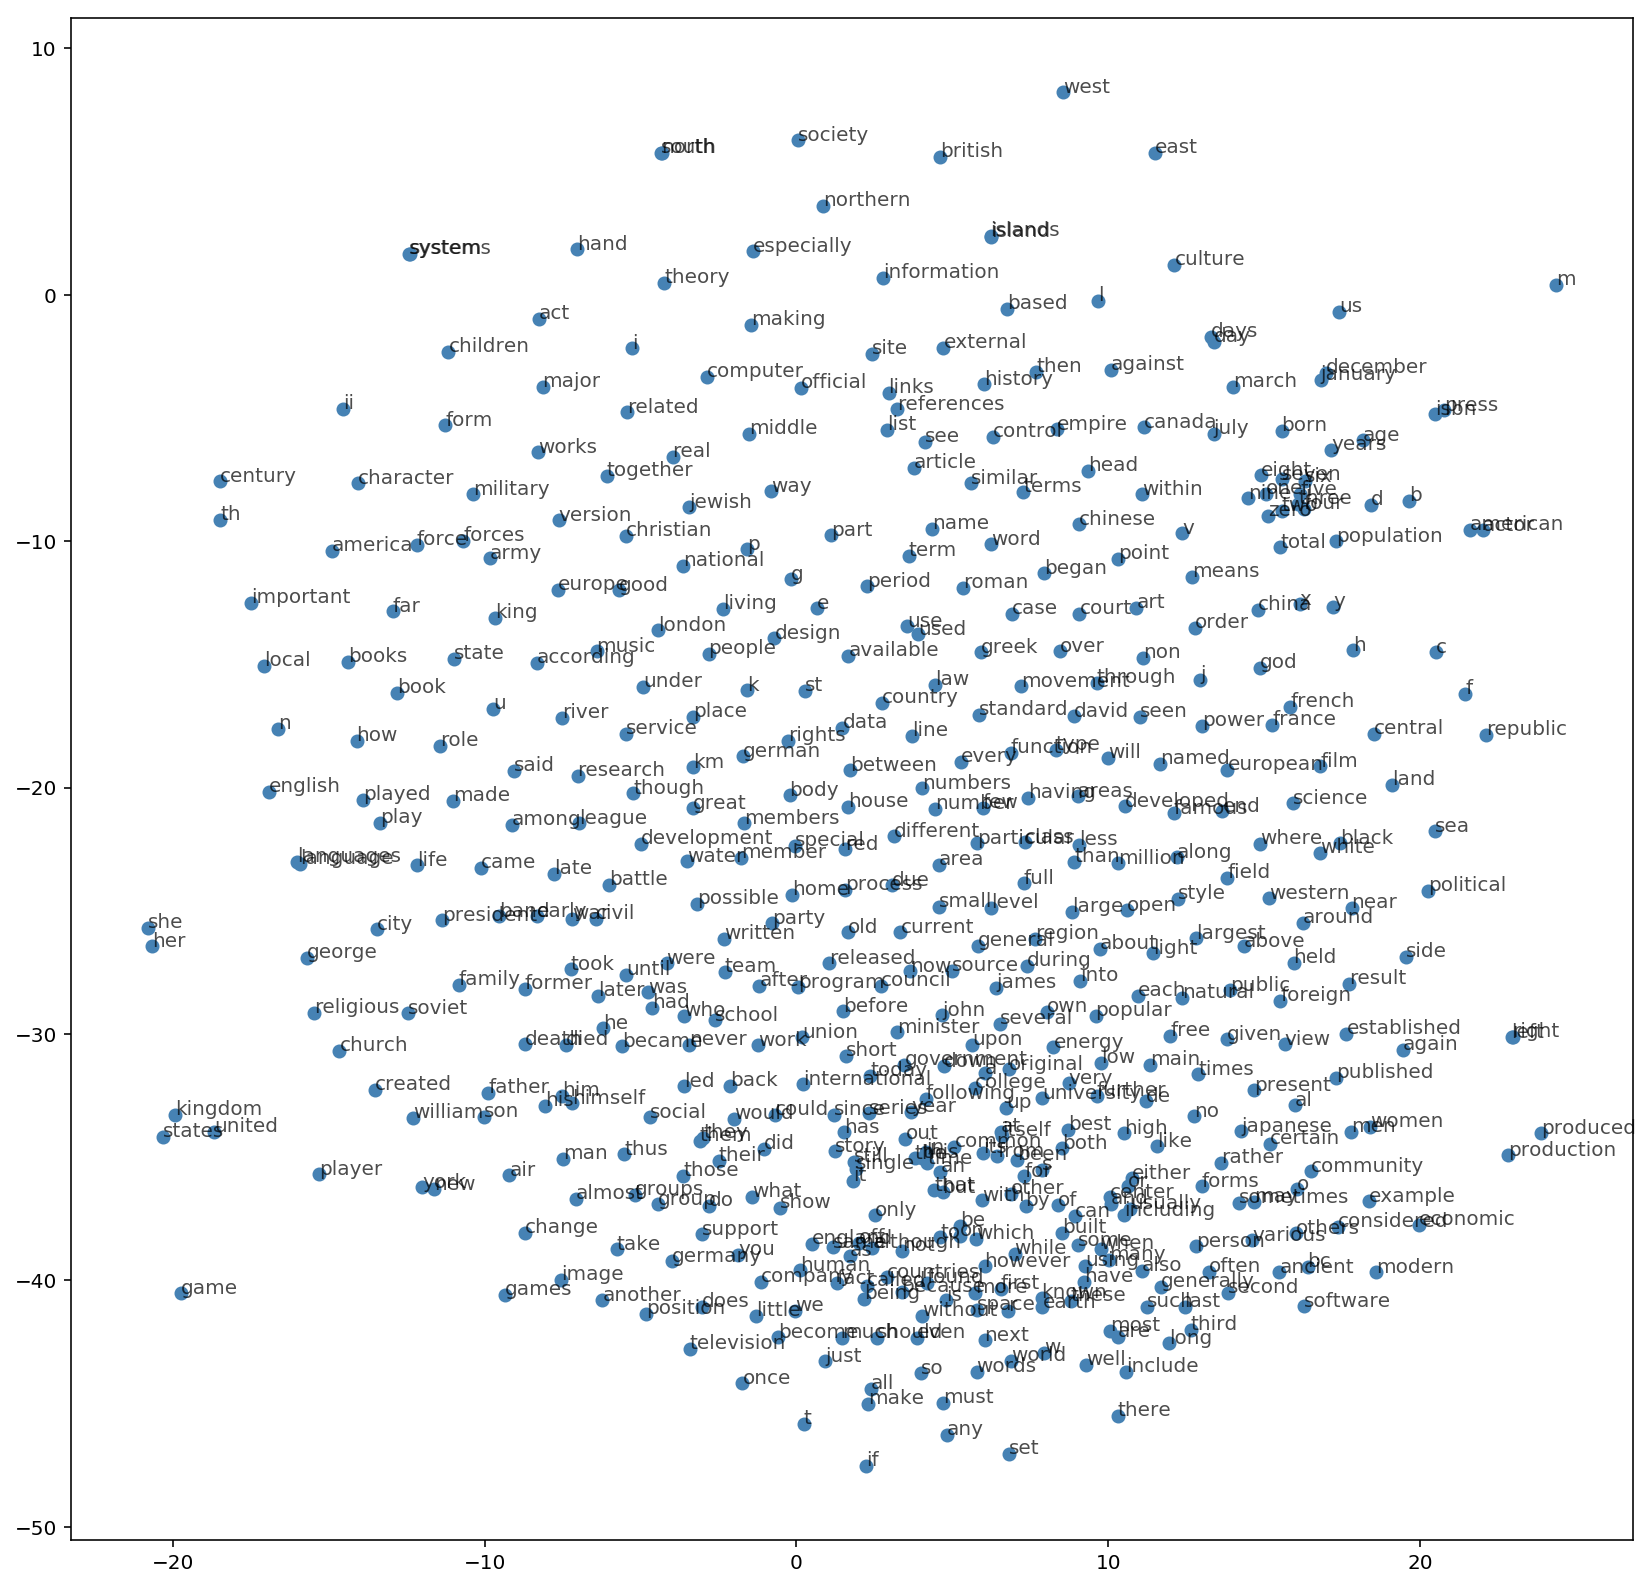

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)